In [41]:
import pandas as pd
training_data = pd.read_csv('/content/CW2-training-dataset.csv')
validation_data = pd.read_csv('/content/CW2-validation-dataset.csv')


In [42]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
genre_counts = training_data[['comedy', 'cult', 'flashback', 'historical',
                     'murder', 'revenge', 'romantic', 'scifi', 'violence']].sum()

genre_counts_dict = genre_counts.to_dict()

print("Number of movies in each genre:")
for genre, count in genre_counts_dict.items():
    print(f"{genre}: {int(count)}")

Number of movies in each genre:
comedy: 1262
cult: 1801
flashback: 1994
historical: 186
murder: 4019
revenge: 1657
romantic: 2006
scifi: 204
violence: 3064


In [44]:
label_columns = ['comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge', 'romantic', 'scifi', 'violence']

# # Calculate class weights for each label
# class_weights = {}
# for i, label in enumerate(label_columns):
#     class_weights[i] = compute_class_weight('balanced', classes=np.array([0, 1]), y=training_data[label])

# print("Class Weights:", class_weights)

In [45]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords - converts the stopwords into a set which is faster in lookups
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into a single string to return text (string)
    processed_text = ' '.join(tokens)

    return processed_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [46]:
# Extract the target columns (genre labels)
label_columns = ['comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge', 'romantic', 'scifi', 'violence']
y_train = training_data[label_columns].values
y_validate = validation_data[label_columns].values

In [47]:
training_data['context']= (training_data['title'] + ". " +training_data['plot_synopsis']).apply(preprocess_text)
validation_data['context']= (validation_data['title'] + ". " + validation_data['plot_synopsis']).apply(preprocess_text)

In [48]:
# Calculate the number of words in each context
training_data['num_words'] = training_data['context'].astype(str).apply(lambda x: len(x.split()))

# Calculate the average number of words
average_length = training_data['num_words'].mean()

# Display the average length
print(f"Average number of words: {average_length}")

Average number of words: 464.2385854426547


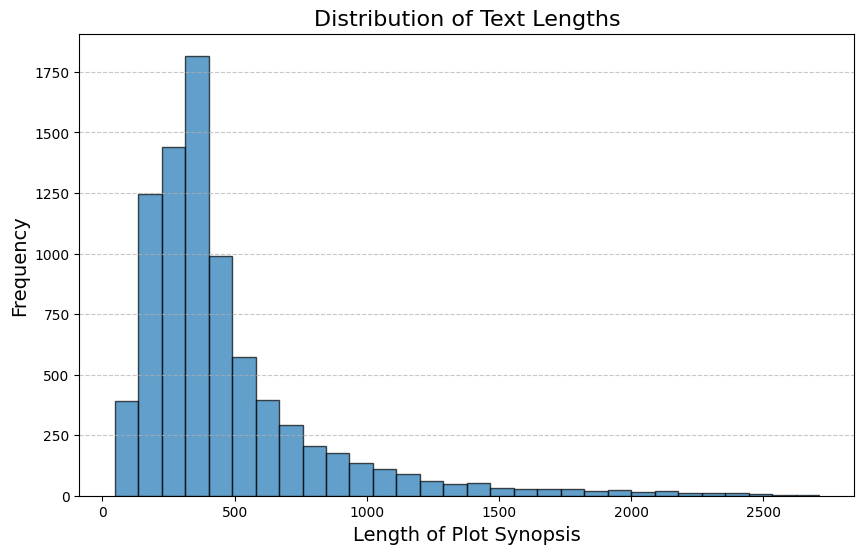

In [49]:
#plot histogram to showcase the length frequency of cleaned plot_synopsis of each movie
plt.figure(figsize=(10, 6))
plt.hist(training_data['num_words'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Length of Plot Synopsis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [50]:
# Initialize tokenizer and parameters for padding/truncating
num_words = 7000  # Vocabulary size of words to their freq
max_len = 400     # Maximum sequence length
tokenizer = Tokenizer(num_words=num_words,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
def padding_truncating(text):
        ''' Fit tokenizer on the tokenized text
            it creates a vocabulary index based on word frequency (dict word:int)
        '''
        tokenizer.fit_on_texts(text)
        '''converts each word to its corresponding number'''
        sequence = tokenizer.texts_to_sequences(text)

        # Apply padding/truncating
        padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
        return padded_sequence,tokenizer


In [51]:
# Apply padding/truncating on training and test sets
X_train_raw = training_data['context']
X_validate_raw = validation_data['context']
X_train,tokenizer = padding_truncating( X_train_raw)
X_validate = tokenizer.texts_to_sequences(X_validate_raw)  # change words to numbers
X_validate = pad_sequences(X_validate, maxlen=max_len, padding='post', truncating='post')

# Check shapes of processed data
print(f"Processed Training data shape: {X_train.shape}")

Processed Training data shape: (8257, 400)


In [52]:
print(X_train.shape) #training data - has the plot of the movie
print(y_train.shape) #target data - has the categories the movie belong to

(8257, 400)
(8257, 9)


# **Build The Model**

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy


In [63]:
# Define the model with dropout
model = Sequential([
    Embedding(input_dim=num_words, output_dim=100, input_length=max_len),  # Embedding layer
    # SpatialDropout1D(0.2),  # Dropout applied to embedding layer
    # Bidirectional(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  # LSTM with dropout
    Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),  # Second LSTM layer
    # Dense(64, activation='relu'),  # Hidden dense layer
    # Dropout(0.5),  # Dropout for hidden layer
    Dense(len(label_columns), activation='sigmoid')  # Output layer for multi-label classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Check the model summary
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
# my_callbacks  = [EarlyStopping(monitor='val_loss',
                              # min_delta=0,
                              # patience=2,
                              # mode='auto')]

In [65]:
# Train the model
history = model.fit(
    X_train, y_train,          # here you pass the inputs and target labels
    epochs=10,                 # Number of epochs
    batch_size=256,             # Batch size
    validation_data=(X_validate, y_validate)
    # callbacks=my_callbacks
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.3748 - loss: 0.3515 - val_accuracy: 0.2988 - val_loss: 0.4288
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.3965 - loss: 0.3412 - val_accuracy: 0.2955 - val_loss: 0.4331
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.4298 - loss: 0.3235 - val_accuracy: 0.3064 - val_loss: 0.4452
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.4418 - loss: 0.3106 - val_accuracy: 0.3005 - val_loss: 0.4560
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.4545 - loss: 0.3006 - val_accuracy: 0.2845 - val_loss: 0.4693
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.4721 - loss: 0.2885 - val_accuracy: 0.2955 - val_loss: 0.4696
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.5008 - loss: 0.2722 - val_accuracy: 0.2896 - val_loss: 0.4831
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5160 - loss: 0.2660 - val_accuracy: 0.2854 - v

In [66]:
# Predict probabilities on the validation data
predicted_probabilities = model.predict(X_validate)

# Apply a threshold to convert probabilities to binary predictions
threshold = 0.4
binary_predictions = (predicted_probabilities > threshold).astype(int)

# Create a DataFrame for the predictions
output_df = pd.DataFrame(binary_predictions, columns=label_columns)

# Add the ID column from validation_data
output_df.insert(0, 'ID', validation_data['ID'])

# Save the DataFrame to a CSV file
output_df.to_csv('validation_output.csv', index=False)

print("Predictions saved to 'validation_output.csv'")

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step
Predictions saved to 'validation_output.csv'


In [69]:
import pandas as pd

test_data = pd.read_csv('/content/CW2-test-dataset.csv')

# Assign column names manually
test_data.columns = ['ID', 'Movie Title', 'Description']

# Combine title and description for context processing
test_data['context'] = test_data['Movie Title'] + ". " + test_data['Description']

# Preprocess the context column (using your existing preprocessing function)
test_data['context'] = test_data['context'].apply(preprocess_text)

# Tokenize and pad the sequences
X_test_raw = test_data['context']
X_test = tokenizer.texts_to_sequences(X_test_raw)  # Convert words to numbers
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

# Predict probabilities for each genre
predicted_probabilities = model.predict(X_test)

# Convert probabilities to binary predictions using the best thresholds
binary_predictions = (predicted_probabilities > 0.4).astype(int)

# Create a DataFrame for the predictions
output_df = pd.DataFrame(binary_predictions, columns=label_columns)

# Add the 'ID' column from the test dataset
output_df.insert(0, 'ID', test_data['ID'])  # First column corresponds to the ID

# Save the DataFrame to a CSV file with headers
output_file = '10953347_task1_code.csv'
output_df.to_csv(output_file, index=False, header=False)

print(f"Predictions saved to '{output_file}'")

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step
Predictions saved to '10953347_task1_code.csv'
